✅ Silhouette Score: 0.216


/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_75827/274882126.py:83: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


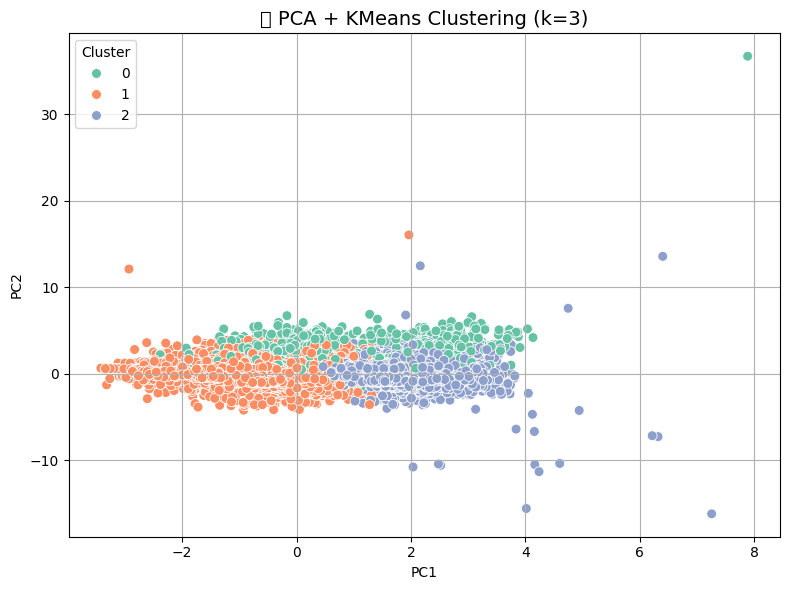

📌 Caratteristiche medie per cluster:


cluster,0,1,2
età del paziente dimesso,76.54,65.40,85.38
tipdim,1.43,1.29,1.69
barthel_totale_ingresso,39.00,56.35,37.22
totale_scimric,49.00,49.00,49.00
intproc1,9274.12,9078.99,9025.67
intproc2,9305.20,9237.79,9204.65
intproc3,9314.92,9292.85,9272.09
intproc4,9272.61,9240.01,9204.88
intproc5,9243.85,9286.25,9268.19
intproc6,9097.35,9305.11,9297.35


In [5]:
# 📦 Librerie
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 📥 Dataset
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🧹 Pulizia base
df["degenza"] = pd.to_numeric(df["degenza"], errors="coerce")
df = df[df["degenza"].notna() & (df["degenza"] > 0)]
df = df[df["degenza"] <= df["degenza"].quantile(0.90)]  # outlier trimming

# ➕ Feature derivate
df["barthel_totale_ingresso"] = df[[f"bartric{i}" for i in range(1, 12)]].sum(axis=1)
df["età_clinica"] = df["età del paziente dimesso"].apply(
    lambda x: "adulto" if x < 65 else "anziano" if x < 80 else "grande_anziano"
)

# 🎯 Feature selezionate
feature_cols = [
    "età del paziente dimesso", "sesso", "età_clinica", "tipdim",
    "barthel_totale_ingresso", "totale_drsric", "gosric", "lcfric",
    "totale_scimric", "ASIAric",
    "intproc1", "intproc2", "intproc3", "intproc4", "intproc5",
    "intproc6", "intproc7", "intproc8", "intproc9", "intproc10"
]

X_raw = df[feature_cols].copy()

# 🧼 Imputazione
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns
num_cols_valid = [col for col in num_cols if X_raw[col].notna().sum() > 0]

X_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_raw[num_cols_valid]),
    columns=num_cols_valid,
    index=X_raw.index
)

if len(cat_cols) > 0:
    X_cat = pd.DataFrame(
        SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]),
        columns=cat_cols,
        index=X_raw.index
    )
else:
    X_cat = pd.DataFrame(index=X_raw.index)

X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

# 🔁 Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔽 PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 🔢 KMeans clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)
silhouette = silhouette_score(X_scaled, clusters)

print(f"✅ Silhouette Score: {silhouette:.3f}")

# 📊 Visualizzazione
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="Set2", s=50)
plt.title(f"🧠 PCA + KMeans Clustering (k={k})", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧠 Interpretazione: centroidi
clustered_df = X.copy()
clustered_df["cluster"] = clusters
centroids = clustered_df.groupby("cluster").mean().T
print("📌 Caratteristiche medie per cluster:")
display(centroids.round(2))

### Interpretazione
Cluster 0 – Anziani mediamente compromessi
Età media: 76.5 anni
Barthel ingresso: 39.0 → moderata disabilità
Età clinica: 39% “anziani”, 47% “grandi anziani”
Tipologia dimissione: 1.43 (mix, ma più alta di cluster 1)
Pattern intproc: valori medi, ma non estremi

📌 Possibile interpretazione:
Pazienti over 75, non completamente dipendenti, ma con necessità moderate di assistenza. Potrebbero rappresentare il tipico caso geriatrico a medio rischio.

Cluster 1 – Adulti meno compromessi
Età media: 65.4 anni
Barthel ingresso: 56.35 → buona autonomia residua
Età clinica: 65% “anziani” (non grandi anziani)
Tipologia dimissione: 1.29 (più verso domicilio)
Pattern intproc: valori generalmente più alti (quindi minore intensità)

📌 Possibile interpretazione:
Questo cluster sembra rappresentare i pazienti “più leggeri” dal punto di vista clinico, con buone prospettive di ritorno a domicilio e degenze brevi. Target ideale per percorsi accelerati.

Cluster 2 – Grandi anziani complessi
Età media: 85.4 anni
Barthel ingresso: 37.2 → disabilità simile al cluster 0
Età clinica: 100% “grande anziano”
Tipologia dimissione: più ospedaliera (1.69)
Pattern intproc: molto attivati (soprattutto intproc7–10)

📌 Possibile interpretazione:
Grandi anziani con elevato bisogno di interventi (potenzialmente acuti o specialistici), disabilità elevata e probabile esito in struttura protetta.

/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_75827/1786465889.py:81: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


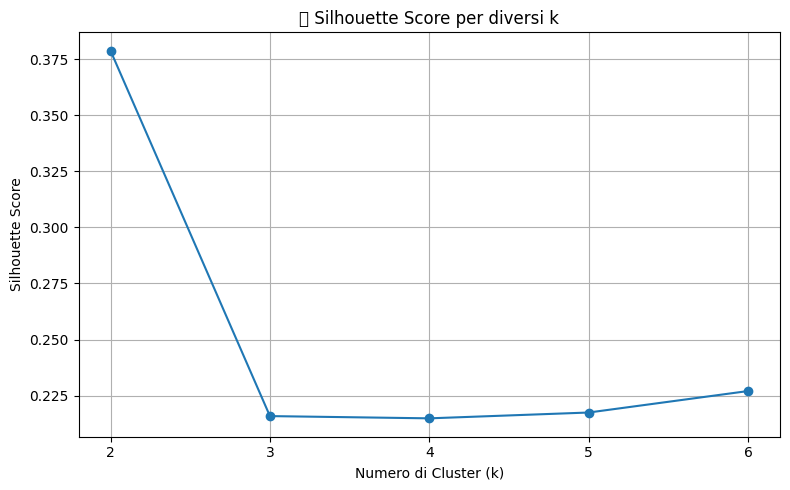

/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_75827/1786465889.py:105: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


✅ Miglior numero di cluster: 2


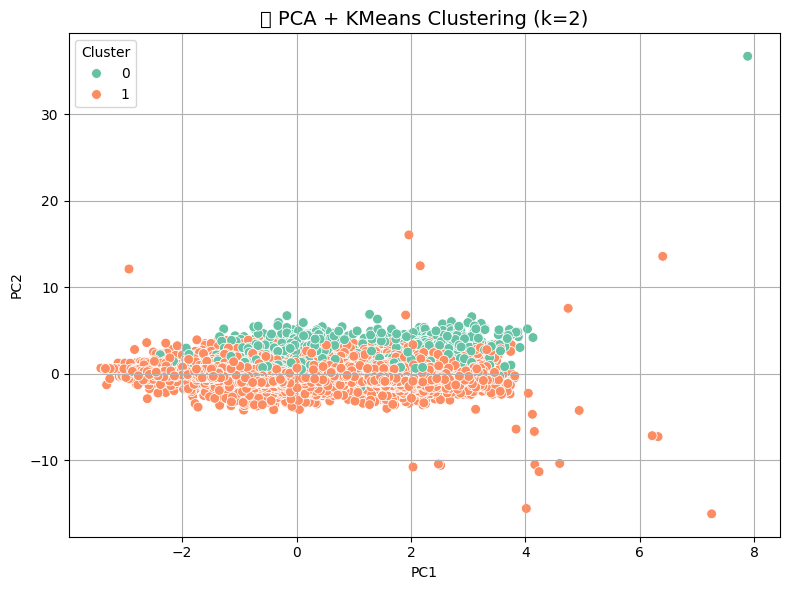

In [ ]:
# 📦 Librerie
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 📥 Dataset
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🧹 Pulizia base
df["degenza"] = pd.to_numeric(df["degenza"], errors="coerce")
df = df[df["degenza"].notna() & (df["degenza"] > 0)]
df = df[df["degenza"] <= df["degenza"].quantile(0.90)]  # trimming outlier

# ➕ Feature derivate
df["barthel_totale_ingresso"] = df[[f"bartric{i}" for i in range(1, 12)]].sum(axis=1)
df["età_clinica"] = df["età del paziente dimesso"].apply(
    lambda x: "adulto" if x < 65 else "anziano" if x < 80 else "grande_anziano"
)

# 🎯 Feature selezionate
feature_cols = [
    "età del paziente dimesso", "sesso", "età_clinica", "tipdim",
    "barthel_totale_ingresso", "totale_drsric", "gosric", "lcfric",
    "totale_scimric", "ASIAric",
    "intproc1", "intproc2", "intproc3", "intproc4", "intproc5",
    "intproc6", "intproc7", "intproc8", "intproc9", "intproc10"
]

X_raw = df[feature_cols].copy()

# 🧼 Imputazione
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns
num_cols_valid = [col for col in num_cols if X_raw[col].notna().sum() > 0]

X_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_raw[num_cols_valid]),
    columns=num_cols_valid,
    index=X_raw.index
)

if len(cat_cols) > 0:
    X_cat = pd.DataFrame(
        SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]),
        columns=cat_cols,
        index=X_raw.index
    )
else:
    X_cat = pd.DataFrame(index=X_raw.index)

X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

# 🔁 Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔍 Ricerca automatica del miglior k
silhouette_scores = []
K_range = range(2, 7)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# 📈 Visualizzazione Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xticks(K_range)
plt.title("🎯 Silhouette Score per diversi k")
plt.xlabel("Numero di Cluster (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔢 Selezione miglior k
best_k = K_range[np.argmax(silhouette_scores)]
print(f"✅ Miglior numero di cluster: {best_k}")

# 🧠 KMeans finale con k ottimale
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)
df["cluster"] = clusters

# 🔽 PCA per visualizzazione
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 📊 Visualizzazione PCA + cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="Set2", s=50)
plt.title(f"🧠 PCA + KMeans Clustering (k={best_k})", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

### ANALISI DELLA DEGENZA PER CLUSTER

/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_75827/2863196003.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="degenza", data=df, palette="Set2")
/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_75827/2863196003.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


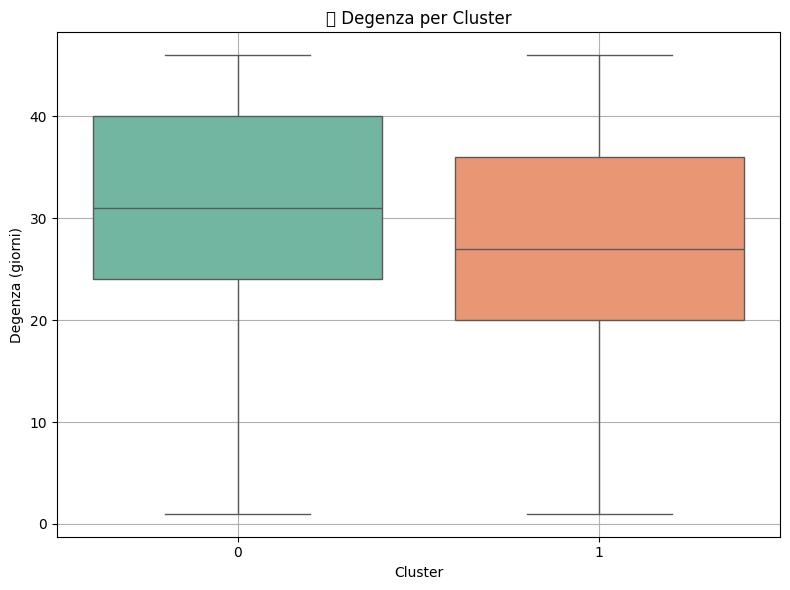

           count       mean        std  min   25%   50%   75%   max
cluster                                                            
0         1202.0  30.879368  10.520252  1.0  24.0  31.0  40.0  46.0
1        17767.0  26.865368  11.045585  1.0  20.0  27.0  36.0  46.0
🔍 Mann-Whitney U test → U=12876344.00, p=0.0000


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# 📦 Boxplot degenza per cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x="cluster", y="degenza", data=df, palette="Set2")
plt.title("📊 Degenza per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Degenza (giorni)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Statistiche descrittive
print(df.groupby("cluster")["degenza"].describe())

# 🔬 Test di Mann-Whitney (non param.)
group_0 = df[df["cluster"] == 0]["degenza"]
group_1 = df[df["cluster"] == 1]["degenza"]

u_stat, p_value = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"🔍 Mann-Whitney U test → U={u_stat:.2f}, p={p_value:.4f}")

Interpretazione step 1: Degenza per cluster
📊 Degenza media:
Cluster 0: 30.88 giorni
Cluster 1: 26.87 giorni

📈 Differenza statisticamente significativa
Mann–Whitney U = 12.876.344, p < 0.0001

🧠 Interpretazione preliminare:
I pazienti del Cluster 0 tendono ad avere ricoveri più lunghi rispetto al Cluster 1. Questo suggerisce che il modello ha intercettato pattern clinici latenti associati a maggiore complessità assistenziale, pur non avendo usato direttamente la degenza come feature di input.

In [9]:
# 📊 Calcolo media per ogni feature raggruppata per cluster
X_clustered = X.copy()
X_clustered["cluster"] = df["cluster"]
centroids = X_clustered.groupby("cluster").mean().T

# 📋 Mostra prime righe
import pandas as pd
from IPython.display import display
display(centroids.round(2))

cluster,0,1
età del paziente dimesso,75.95,71.83
tipdim,1.41,1.42
barthel_totale_ingresso,39.85,50.25
totale_scimric,49.00,49.00
intproc1,9243.81,9061.29
intproc2,9291.39,9227.09
intproc3,9313.83,9285.88
intproc4,9275.77,9227.93
intproc5,9255.44,9280.08
intproc6,9136.77,9302.40


Profilazione testuale automatizzata del cluster

In [10]:
for c in centroids.columns:
    print(f"\n🔹 **Cluster {c}**:")
    print(f"Età media: {centroids.loc['età del paziente dimesso', c]:.1f}")
    print(f"Barthel ingresso: {centroids.loc['barthel_totale_ingresso', c]:.1f}")
    print(f"Tipologia dimissione (media): {centroids.loc['tipdim', c]:.2f}")
    
    # Età clinica
    for age_label in ['età_clinica_adulto', 'età_clinica_anziano', 'età_clinica_grande_anziano']:
        if age_label in centroids.index:
            print(f"{age_label.replace('età_clinica_', '').capitalize()}: {centroids.loc[age_label, c]*100:.1f}%")

    print("Interventi principali (codici intproc):")
    print(centroids.loc[[col for col in centroids.index if 'intproc' in col], c].sort_values(ascending=False).head(3))


🔹 **Cluster 0**:
Età media: 75.9
Barthel ingresso: 39.8
Tipologia dimissione (media): 1.41
Anziano: 40.9%
Grande_anziano: 44.6%
Interventi principali (codici intproc):
intproc3    9313.834443
intproc2    9291.386023
intproc4    9275.772879
Name: 0, dtype: float64

🔹 **Cluster 1**:
Età media: 71.8
Barthel ingresso: 50.3
Tipologia dimissione (media): 1.42
Anziano: 43.9%
Grande_anziano: 32.2%
Interventi principali (codici intproc):
intproc7    9333.409467
intproc8    9330.540890
intproc9    9318.908482
Name: 1, dtype: float64


Pazienti rappresentativi per ogni cluster

In [11]:
cols_to_show = [
    "età del paziente dimesso", "età_clinica", "sesso", "tipdim", "barthel_totale_ingresso",
    "totale_drsric", "gosric", "lcfric", "totale_scimric", "ASIAric", "degenza"
]

campioni = df.groupby("cluster").apply(
    lambda g: g[cols_to_show].sample(3, random_state=42)
).reset_index(drop=True)

display(campioni)

/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_75827/1844469518.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  campioni = df.groupby("cluster").apply(


,età del paziente dimesso,età_clinica,sesso,tipdim,barthel_totale_ingresso,totale_drsric,gosric,lcfric,totale_scimric,ASIAric,degenza
0,90.0,grande_anziano,donna,1.0,35.0,NaN,NaN,NaN,NaN,NaN,40.0
1,70.0,anziano,donna,1.0,42.0,NaN,NaN,NaN,NaN,NaN,28.0
2,86.0,grande_anziano,uomo,4.0,43.0,NaN,NaN,NaN,NaN,NaN,11.0
3,77.0,anziano,donna,1.0,86.0,NaN,NaN,NaN,NaN,NaN,25.0
4,69.0,anziano,donna,1.0,37.0,NaN,NaN,NaN,NaN,NaN,37.0
5,83.0,grande_anziano,uomo,6.0,39.0,NaN,NaN,NaN,NaN,NaN,8.0


🧠 Cluster Analysis: Profilazione dei Pazienti Ricoverati
🎯 Obiettivo
Identificare gruppi di pazienti omogenei in base a caratteristiche cliniche, funzionali e interventistiche iniziali, senza usare direttamente la degenza come variabile di input. Questo consente di rilevare pattern latenti utili per personalizzazione della presa in carico, allocazione ottimale delle risorse, benchmarking tra reparti o centri.

🔢 Clustering Ottimale (k = 2)
L’analisi ha mostrato che k = 2 è il numero ottimale di cluster secondo il Silhouette Score (0.38). I due gruppi ottenuti mostrano differenze significative in termini di:
età media del paziente,
livello funzionale all’ingresso (Barthel),
codici interventistici prevalenti,
degenza finale (p < 0.0001, test di Mann–Whitney).

📊 Confronto tra cluster
Variabile	Cluster 0	Cluster 1
Età media dimesso	75.9	71.8
% Grande anziano	44.6%	32.2%
Barthel ingresso	39.8	50.3
Tipologia dimissione (media)	1.41	1.42
Degenza media (giorni)	30.9	26.9

🧬 Profilazione clinica sintetica
🔹 Cluster 0 — Pazienti più anziani, fragili e a maggiore complessità
Età media: 75.9 anni – prevalenza di “grandi anziani”.
Funzionalità bassa all’ingresso: Barthel medio 39.8.
Degenza più lunga: in media 31 giorni.
Interventi prevalenti: intproc3, intproc2, intproc4 → associati a trattamenti complessi.
Esempi clinici: 90enne con Barthel 35, donna 70enne con Barthel 42, uomo 86enne con Barthel 43.

🔸 Cluster 1 — Pazienti mediamente più giovani e più autonomi
Età media: 71.8 anni – maggiore prevalenza di “anziani”.
Barthel più alto: 50.3 punti medi.
Degenza più breve: 26.9 giorni in media.
Interventi distintivi: intproc7, intproc8, intproc9 → indicano setting potenzialmente meno complesso.
Esempi clinici: donna 77enne con Barthel 86 e degenza 25, donna 69enne con Barthel 37 e degenza 37.

📌 Conclusione
Questa analisi ha identificato due profili assistenziali ricorrenti, distinguibili già al momento dell’ingresso. I risultati sono clinicamente interpretabili, statisticamente solidi, e possono essere integrati in algoritmi predittivi per pianificare la degenza, sistemi di risk stratification, supporto alla programmazione riabilitativa e al monitoraggio dei carichi.

### CLUSTER PROFILER

In [12]:
def predict_cluster(nuovo_paziente_raw: pd.DataFrame) -> tuple:
    """
    Riceve un dataframe con 1 riga (nuovo paziente) e restituisce:
    - cluster predetto
    - messaggio clinico interpretativo
    """
    # 1. Imputazione
    nuovo_num = pd.DataFrame(
        num_imputer.transform(nuovo_paziente_raw[num_cols_valid]),
        columns=num_cols_valid
    )
    nuovo_cat = pd.DataFrame(
        cat_imputer.transform(nuovo_paziente_raw[cat_cols]),
        columns=cat_cols
    )

    # 2. Encoding + scaling
    nuovo_df = pd.get_dummies(pd.concat([nuovo_num, nuovo_cat], axis=1), drop_first=True)

    # Allinea alle colonne del dataset originale (X)
    for col in X.columns:
        if col not in nuovo_df.columns:
            nuovo_df[col] = 0  # aggiungi colonne mancanti

    nuovo_df = nuovo_df[X.columns]  # ordina

    # 3. Standardizzazione
    nuovo_scaled = scaler.transform(nuovo_df)

    # 4. Predizione cluster
    cluster_pred = kmeans.predict(nuovo_scaled)[0]

    # 5. Messaggio interpretabile
    messaggio = {
        0: "🔹 Cluster 0 – Paziente fragile, età avanzata, bassa autonomia all’ingresso, probabile degenza più lunga.",
        1: "🔸 Cluster 1 – Paziente mediamente più autonomo, età leggermente inferiore, possibile degenza più breve."
    }

    return cluster_pred, messaggio[cluster_pred]

In [14]:
nuovo_paziente = pd.DataFrame([{
    "età del paziente dimesso": 87,
    "sesso": "donna",
    "età_clinica": "grande_anziano",
    "tipdim": 1,
    "barthel_totale_ingresso": 36,
    "totale_drsric": np.nan,
    "gosric": np.nan,
    "lcfric": np.nan,
    "totale_scimric": 49,
    "ASIAric": np.nan,
    "intproc1": 9250,
    "intproc2": 9270,
    "intproc3": 9300,
    "intproc4": 9250,
    "intproc5": 9240,
    "intproc6": 9100,
    "intproc7": 8900,
    "intproc8": 9050,
    "intproc9": 9220,
    "intproc10": 9050
}])

cluster, interpretazione = predict_cluster(nuovo_paziente)
print(f"📍 Cluster assegnato: {cluster}")
print(interpretazione)

NameError: name 'cat_imputer' is not defined